In [1]:
!pip install transformers torch seaborn wordcloud

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from transformers import pipeline
import torch
import re
import warnings
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

warnings.filterwarnings('ignore')

train = pd.read_csv('/content/train (2).csv')
test = pd.read_csv('/content/test (1).csv')
val = pd.read_csv('/content/val.csv')

print('Train Dataset:\n', train.head())
print('\nTest Dataset:\n', test.head())
print('\nValidation Dataset:\n', val.head())

Train Dataset:
    tweet_id     user_handle            timestamp  ... retweets likes sentiment
0         1        @user123  2024-11-03 08:45:00  ...      120   450  positive
1         2    @politicsFan  2024-11-03 09:15:23  ...       85   300  positive
2         3  @greenAdvocate  2024-11-03 10:05:45  ...       60   200  positive
3         4     @indieVoice  2024-11-03 11:20:10  ...       40   150   neutral
4         5   @libertyLover  2024-11-03 12:35:55  ...       30   120  positive

[5 rows x 9 columns]

Test Dataset:
    tweet_id       user_handle            timestamp  ... retweets likes sentiment
0       501         @user1068  2025-02-11 08:30:10  ...       85   320  positive
1       502     @politicsNew2  2025-02-11 09:15:20  ...      100   450  positive
2       503  @greenVisionary2  2025-02-11 10:05:35  ...       60   200  positive
3       504    @indieWatcher2  2025-02-11 11:25:40  ...       30   120   neutral
4       505      @libertyFan4  2025-02-11 12:40:50  ...       50   

In [8]:
print('Train Dataset Info:')
train.info()

print('\nTest Dataset Info:')
test.info()

print('\nValidation Dataset Info:')
val.info()

print('\nDuplicate entries in Train:', train.duplicated().sum())
print('Duplicate entries in Test:', test.duplicated().sum())

print('\nNumerical Features Summary:')
print(train.describe())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     500 non-null    int64 
 1   user_handle  500 non-null    object
 2   timestamp    500 non-null    object
 3   tweet_text   500 non-null    object
 4   candidate    500 non-null    object
 5   party        500 non-null    object
 6   retweets     500 non-null    int64 
 7   likes        500 non-null    int64 
 8   sentiment    500 non-null    object
dtypes: int64(3), object(6)
memory usage: 35.3+ KB

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     50 non-null     int64 
 1   user_handle  50 non-null     object
 2   timestamp    50 non-null     object
 3   tweet_text   50 non-null     object
 4   c

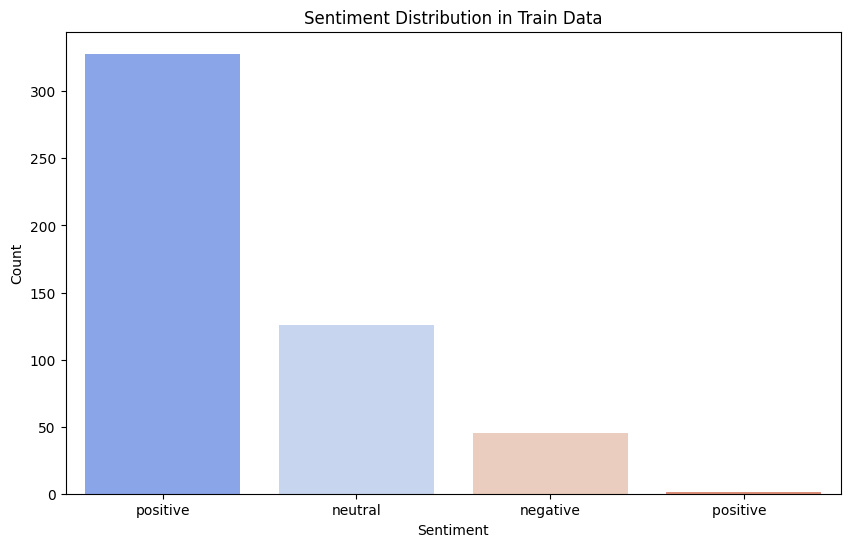

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=train, palette='coolwarm')
plt.title('Sentiment Distribution in Train Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

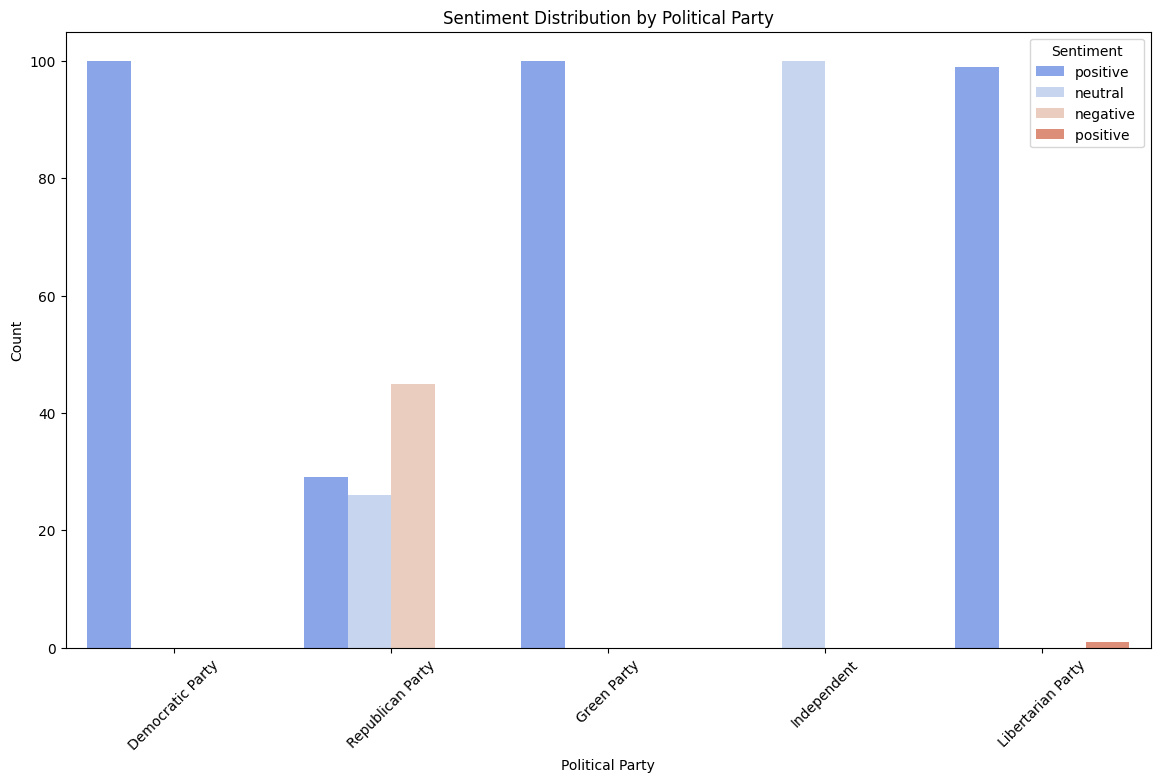

In [11]:
plt.figure(figsize=(14, 8))
sns.countplot(x='party', hue='sentiment', data=train, palette='coolwarm')
plt.title('Sentiment Distribution by Political Party')
plt.xlabel('Political Party')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

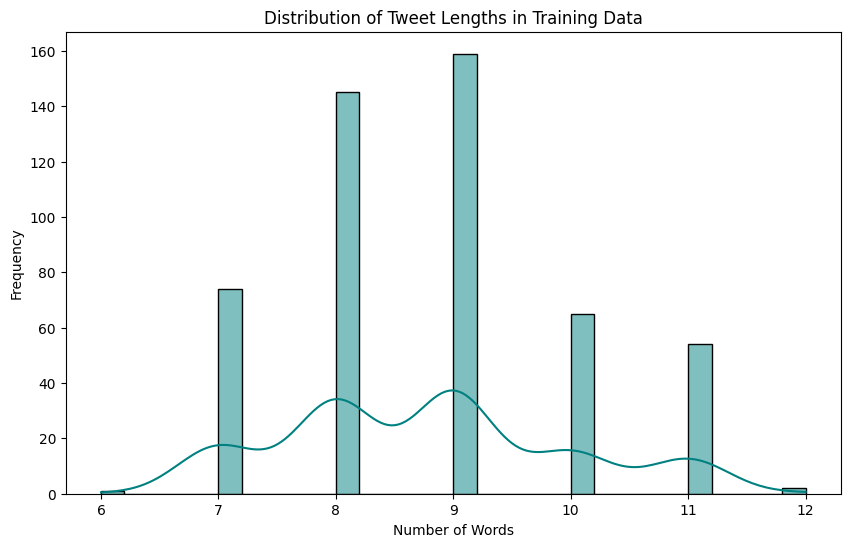

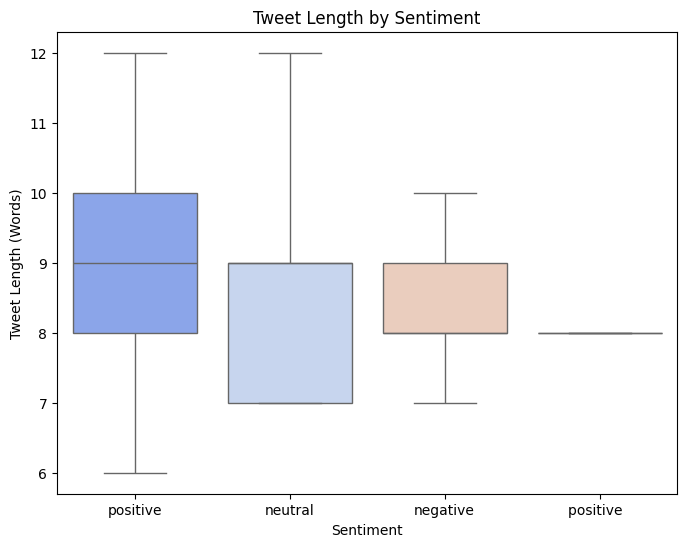

In [21]:
train['tweet_length'] = train['tweet_text'].apply(lambda x: len(x.split()))
test['tweet_length'] = test['tweet_text'].apply(lambda x: len(x.split()))
val['tweet_length'] = val['tweet_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train['tweet_length'], bins=30, kde=True, color='teal')
plt.title('Distribution of Tweet Lengths in Training Data')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='tweet_length', data=train, palette='coolwarm')
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length (Words)')
plt.show()

<Figure size 1600x800 with 0 Axes>

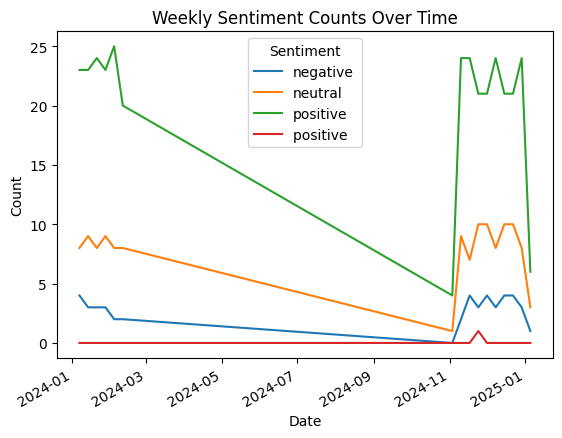

In [25]:
# Convert timestamp to datetime if 'timestamp' is a column, otherwise skip
if 'timestamp' in train.columns:
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    val['timestamp'] = pd.to_datetime(val['timestamp'])

    # Set timestamp as index for train data
    train.set_index('timestamp', inplace=True)

# Resample to weekly frequency and count sentiments
weekly_sentiment = train.groupby([pd.Grouper(freq='W'), 'sentiment']).size().unstack().fillna(0)


# Plot time series of sentiments
plt.figure(figsize=(16, 8))
weekly_sentiment.plot()
plt.title('Weekly Sentiment Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

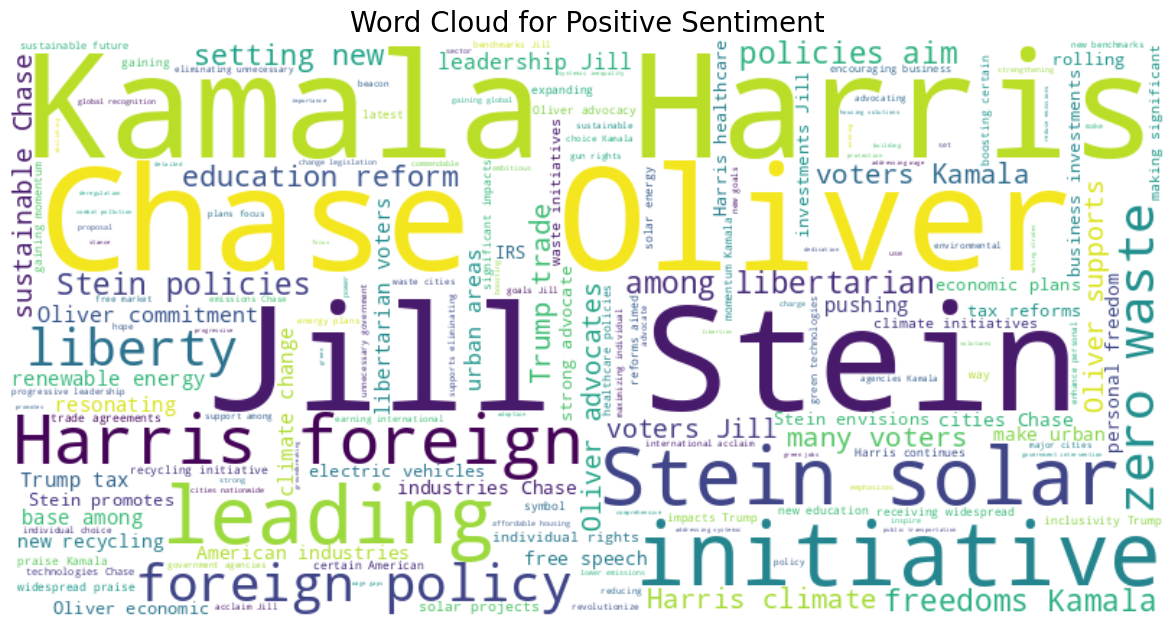

No tweets found for sentiment: neural


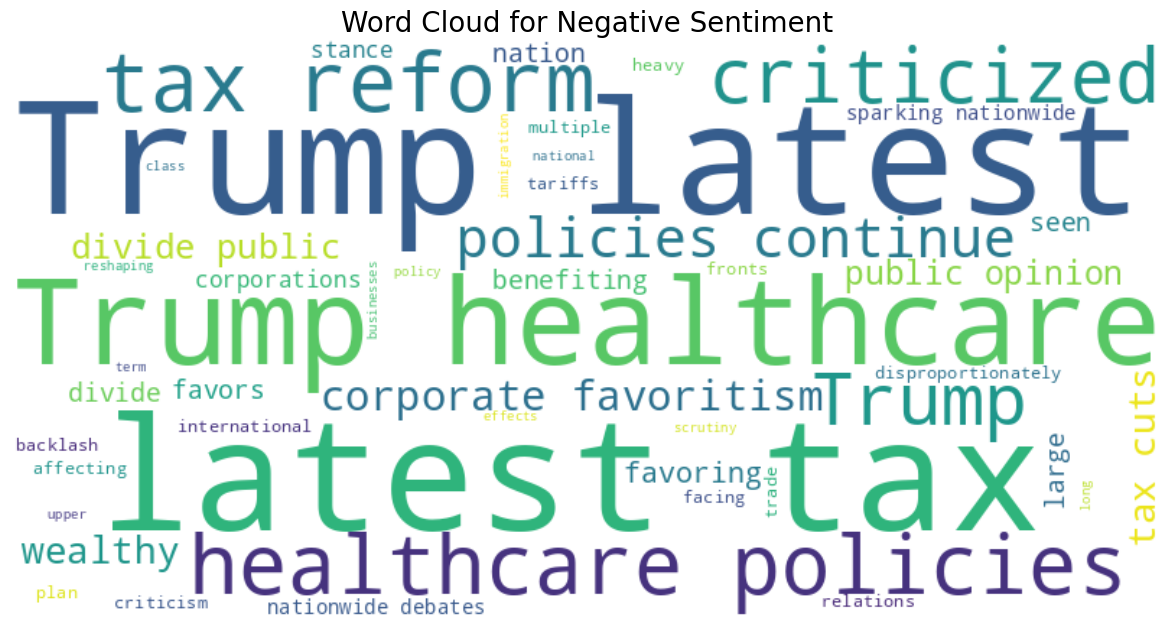

In [29]:
def generate_wordcloud(text, title):
  # Convert the pandas series to a string
  text_str = ' '.join(text.astype(str).tolist())

  # Generate the word cloud
  wordcloud = WordCloud(width=800, height=400,
                        background_color='white',
                        stopwords=STOPWORDS).generate(text_str)
  plt.figure(figsize=(15, 7.5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title, fontsize=20)
  plt.axis('off')
  plt.show()

for sentiment in ['positive', 'neural', 'negative']:
  subset = train[train['sentiment'] == sentiment]

  # Check if the subset is empty
  if subset.empty:
    print(f"No tweets found for sentiment: {sentiment}")
    continue  # Skip to the next sentiment

  generate_wordcloud(subset['tweet_text'], f'Word Cloud for {sentiment.capitalize()} Sentiment')

In [33]:
# Combine all datasets for preprocessing
data = pd.concat([train.reset_index(), test.reset_index(), val.reset_index()], ignore_index=True)

# Function to clean tweet text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    return text

# Apply cleaning
data['clean_text'] = data['tweet_text'].apply(clean_text)

# Display cleaned text
data[['tweet_text', 'clean_text']].head()

,tweet_text,clean_text
0,Excited to see Kamala Harris leading the Democ...,excited to see kamala harris leading the democ...
1,Donald Trump's policies are the best for our e...,donald trumps policies are the best for our ec...
2,Jill Stein's environmental plans are exactly w...,jill steins environmental plans are exactly wh...
3,Robert Kennedy offers a fresh perspective outs...,robert kennedy offers a fresh perspective outs...
4,Chase Oliver's libertarian stance promotes tru...,chase olivers libertarian stance promotes true...


In [34]:
print('Missing Values in Combined Data:\n', data.isnull().sum())

print('\nAfter Handling Missing Values:\n', data.isnull().sum())

Missing Values in Combined Data:
 timestamp         0
tweet_id          0
user_handle       0
tweet_text        0
candidate         0
party             0
retweets          0
likes             0
sentiment         0
tweet_length      0
index           500
clean_text        0
dtype: int64

After Handling Missing Values:
 timestamp         0
tweet_id          0
user_handle       0
tweet_text        0
candidate         0
party             0
retweets          0
likes             0
sentiment         0
tweet_length      0
index           500
clean_text        0
dtype: int64


In [35]:
from sklearn.preprocessing import LabelEncoder

le_party = LabelEncoder()
data['party_encoded'] = le_party.fit_transform(data['party'])

sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
data['sentiment_encoded'] = data['sentiment'].map(sentiment_mapping)

train = data.iloc[:500].copy()
test = data.iloc[500:550].copy()
val = data.iloc[550:600].copy()

train[['party', 'party_encoded', 'sentiment', 'sentiment_encoded']].head()

,party,party_encoded,sentiment,sentiment_encoded
0,Democratic Party,0,positive,2.0
1,Republican Party,4,positive,2.0
2,Green Party,1,positive,2.0
3,Independent,2,neutral,1.0
4,Libertarian Party,3,positive,2.0


In [37]:
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

sample_tweet = train['tweet_text'].iloc[0]
print('Sample Tweet', sample_tweet)
print('Sentiment Analysis Result:', sentiment_pipeline(sample_tweet))

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Sample Tweet Excited to see Kamala Harris leading the Democratic charge!
Sentiment Analysis Result: [{'label': 'POSITIVE', 'score': 0.9997492432594299}]


In [38]:
def analyze_sentiment(text):
  try:
    result = sentiment_pipeline(text[:512])[0]

    return result['label'], result['score']
  except Exception as e:
    return 'ERROR', 0

train[['predicted_sentiment', 'confidence']] = train['tweet_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

val[['predicted_sentiment', 'confidence']] = val['tweet_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

test[['predicted_sentiment', 'confidence']] = test['tweet_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

train[['tweet_text', 'predicted_sentiment', 'confidence']].head()

,tweet_text,predicted_sentiment,confidence
0,Excited to see Kamala Harris leading the Democ...,POSITIVE,0.999749
1,Donald Trump's policies are the best for our e...,POSITIVE,0.999732
2,Jill Stein's environmental plans are exactly w...,POSITIVE,0.999530
3,Robert Kennedy offers a fresh perspective outs...,POSITIVE,0.999691
4,Chase Oliver's libertarian stance promotes tru...,POSITIVE,0.998540


In [39]:
val['predicted_sentiment'] = val['tweet_text'].apply(lambda x: analyze_sentiment(x)[0])

val['predicted_sentiment'] = val['predicted_sentiment'].str.lower()

val['predicted_sentiment'] = pd.Categorical(val['predicted_sentiment'], categories=['negative', 'neutral', 'positive'])

if val['predicted_sentiment'].isnull().any():
  print("Warning: Missing predicted sentiments found. Filling with 'NEUTRAL'.")
  val['predicted_sentiment'] = val['predicted_sentiment'].fillna('neutral')

print("Unique values in val['sentiment]:", val['sentiment'].unique())
print("Unique values in val['predicted_sentiment']:", val['predicted_sentiment'].unique())

print(classification_report(val['sentiment'], val['predicted_sentiment'], target_names=['negative', 'neutral', 'positive']))

Unique values in val['sentiment]: ['positive' 'neutral' 'negative']
Unique values in val['predicted_sentiment']: ['positive', 'negative']
Categories (3, object): ['negative', 'neutral', 'positive']
              precision    recall  f1-score   support

    negative       0.20      0.33      0.25         3
     neutral       0.00      0.00      0.00        13
    positive       0.73      0.97      0.84        34

    accuracy                           0.68        50
   macro avg       0.31      0.43      0.36        50
weighted avg       0.51      0.68      0.58        50



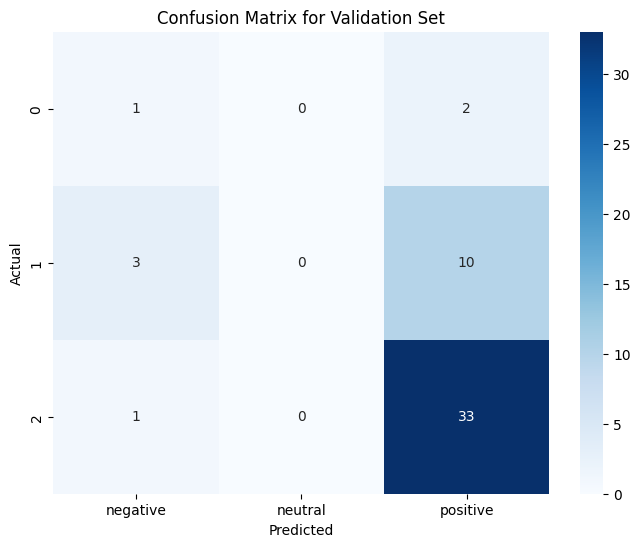

In [40]:
cm = confusion_matrix(val['sentiment'], val['predicted_sentiment'], labels=['negative', 'neutral', 'positive'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'])

plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

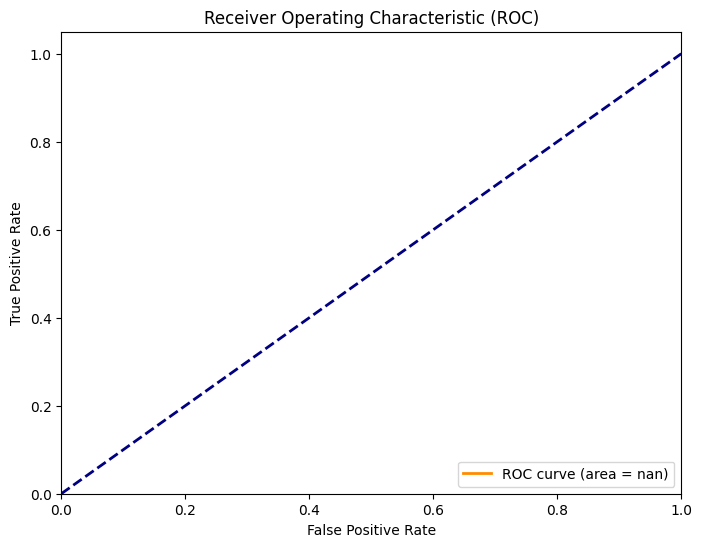

In [41]:
y_val_binarized = label_binarize(val['sentiment'], classes=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
n_classes = y_val_binarized.shape[1]

y_prob = val['confidence']
y_true = (val['sentiment'] == 'POSITIVE').astype(int)

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

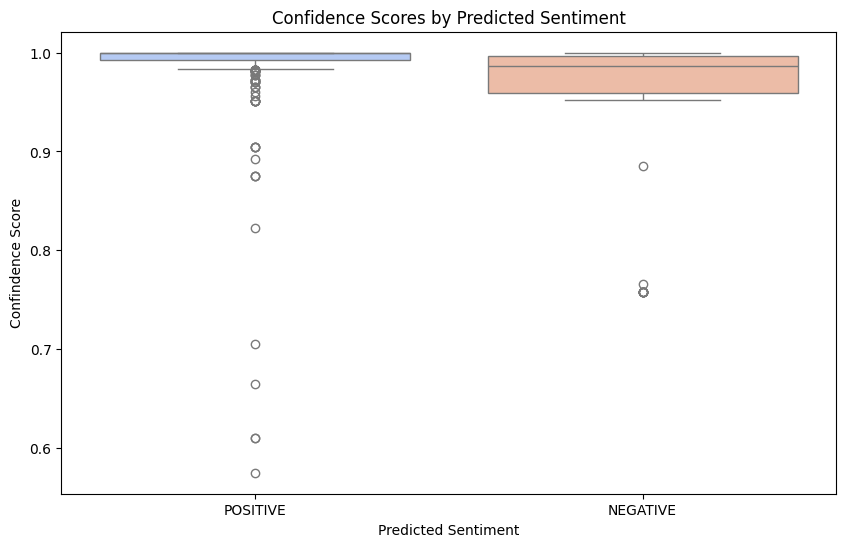

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='predicted_sentiment', y='confidence', data=train, palette='coolwarm')
plt.title('Confidence Scores by Predicted Sentiment')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Confindence Score')
plt.show()

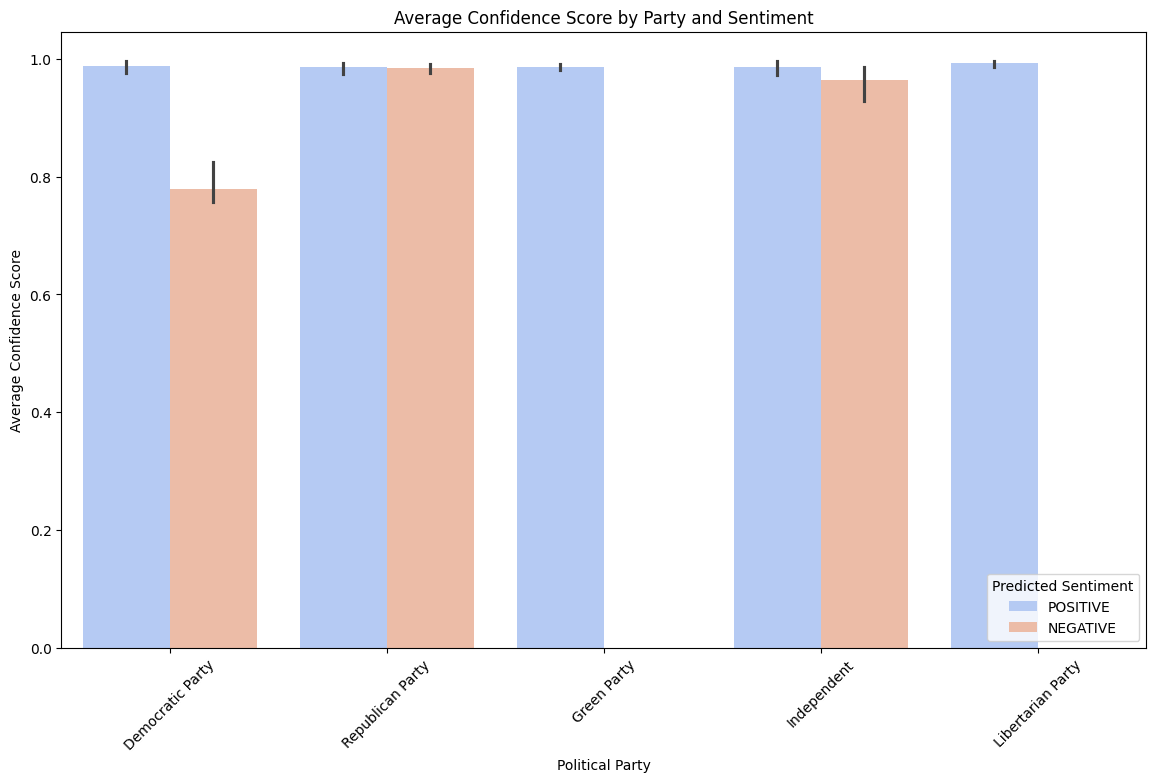

In [43]:
plt.figure(figsize=(14, 8))
sns.barplot(x='party', y='confidence', hue='predicted_sentiment', data=train, palette='coolwarm')
plt.title('Average Confidence Score by Party and Sentiment')
plt.xlabel('Political Party')
plt.ylabel('Average Confidence Score')
plt.xticks(rotation=45)
plt.legend(title='Predicted Sentiment')
plt.show()